# Consensus algorithm

In this example we'll show how to run a simple consensus algorithm.

## Background

We consider a network of `num_clients` peer clients. Each client $i$ maintains some local value $x_i^t$ and is connected to a subset of the other clients in the network, defined as the set of its neighbors $\mathcal{N}_i$.

The goal of all the clients is to reach consensus on their local values by communicating with their peers for a certain number of iterations $T$. 
In other terms, they want to cooperatively compute a weighted average of their initial values $x_i^0$.

The consensus algorithm works by having each client updating its local value as

$$x_i^{t+1} = \sum_{j\in\mathcal{N}_i}a_{ji}x_j^t$$

where $a_{ji}$ is the weight associated by client $i$ to client $j$ and $\sum_{j=1}^N a_{ji}=1$ for all $i$.

## Setup
Let's assume we have $N=5$ clients and generate a random configuration.

In [1]:
from nvflare.app_opt.p2p.utils.config_generator import generate_random_network
from nvflare.app_opt.p2p.types import Config

# generate random config
num_clients=5
network, adjacency_matrix = generate_random_network(num_clients=num_clients)
config = Config(network=network, extra={"iterations": 50})

By inspecting the config we can see the initial values of each client as well as the network topology.

In [2]:
from rich import print

print(config)

Config(
    network=Network(
        nodes=[
            Node(
                id='site-1',
                neighbors=[
                    Neighbor(id='site-2', weight=0.3333333432674408),
                    Neighbor(id='site-4', weight=0.3333333432674408)
                ]
            ),
            Node(id='site-2', neighbors=[Neighbor(id='site-1', weight=0.3333333432674408)]),
            Node(
                id='site-3',
                neighbors=[
                    Neighbor(id='site-4', weight=0.3333333432674408),
                    Neighbor(id='site-5', weight=0.3333333432674408)
                ]
            ),
            Node(
                id='site-4',
                neighbors=[
                    Neighbor(id='site-1', weight=0.3333333432674408),
                    Neighbor(id='site-3', weight=0.3333333432674408)
                ]
            ),
            Node(id='site-5', neighbors=[Neighbor(id='site-3', weight=0.3333333432674408)])
        ]
    ),
    extra={'iterations': 50}
)

## Instantiating and running the distributed algorithm

Now that we have all the configurations, we can instantiate the clients and a controller.

In [3]:
from nvflare.job_config.api import FedJob
from nvflare.app_opt.p2p.executors import ConsensusExecutor
from nvflare.app_opt.p2p.controllers import DistOptController

# Create job
job = FedJob(name="consensus")

# send controller to server
controller = DistOptController(config=config)
job.to_server(controller)

# Add clients
for i in range(num_clients):
    executor = ConsensusExecutor() # the executor will be initialized with a random value
    job.to(executor, f"site-{i+1}")

Finally, we can run the algorithm

In [4]:
# run
job.export_job("./tmp/job_configs")
job.simulator_run("./tmp/runs/consensus")

2025-02-03 10:22:52,438 - SimulatorRunner - INFO - Create the Simulator Server.
2025-02-03 10:22:52,439 - CoreCell - INFO - server: creating listener on tcp://0:55189
2025-02-03 10:22:52,633 - CoreCell - INFO - server: created backbone external listener for tcp://0:55189
2025-02-03 10:22:52,633 - ConnectorManager - INFO - 15299: Try start_listener Listener resources: {'secure': False, 'host': 'localhost'}
2025-02-03 10:22:52,634 - conn_manager - INFO - Connector [CH00002 PASSIVE tcp://0:16697] is starting
2025-02-03 10:22:53,139 - CoreCell - INFO - server: created backbone internal listener for tcp://localhost:16697
2025-02-03 10:22:53,139 - conn_manager - INFO - Connector [CH00001 PASSIVE tcp://0:55189] is starting
2025-02-03 10:22:53,140 - AuxRunner - INFO - registered aux handler for topic ObjectStreamer.Request
2025-02-03 10:22:53,140 - AuxRunner - INFO - registered aux handler for topic ObjectStreamer.Abort
2025-02-03 10:22:53,141 - Cell - INFO - Register blob CB for channel='aux_

Now, since in this toy example we have access to both the intial values and the adjacency matrix, we can compute the consensus value at which the clients will converge.

In [5]:
import torch

from nvflare.app_opt.p2p.utils.topology import get_matrix_steady_state

history = {
    f"site-{i+1}": torch.load(f"tmp/runs/consensus/site-{i+1}/value_sequence.pt") for i in range(num_clients)
}
x0=torch.tensor([h[0] for name, h in history.items()]).t()
consensus_value = x0 @ get_matrix_steady_state(adjacency_matrix)
print(f"Consensus value: {consensus_value}")

/var/folders/82/970ljrw529v0chx2svm8gwwr0000gp/T/ipykernel_15268/4202699194.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  f"site-{i+1}": torch.load(f"tmp/runs/consensu

Consensus value: 0.2560408115386963

By inspecting the history/results, we can easily see that all the clients successfully converged to the expected consensus value. 

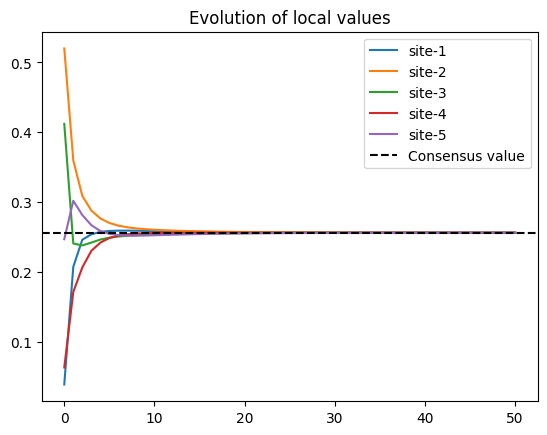

In [6]:
import matplotlib.pyplot as plt

# plot results
plt.figure()
for i in range(num_clients):
    plt.plot(history[f"site-{i+1}"], label=f"site-{i+1}")
plt.axhline(y=consensus_value, color='k', linestyle="--", label="Consensus value")
plt.legend()
plt.title("Evolution of local values")
plt.show()